# Changepoint detection
In this notebook, we present a tool for detecting and recognizing changepoints in a time series. Given a set of intervals in the time series, where changepoints may lie, our tool essentially ranks those intervals with respect to the possibility of containing a changepoint.

We focus on a particular use case, where each point in the input time series contains measurements for power production and various environmental parameters in a solar panel park, and we are looking for changepoints among all sufficiently heavy rains. Detecting a changepoint when a rain occurred is considered an indication that  soiling affected productivity of the park before the rain, but the rain lead to improved productivity through washing off dirt from the panels.  

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
from my_functions import *


# Read input

In [2]:
file_strings2020 = "../soiling_data/PV1 -20200101T000000v0/PV1 -20200101T000000_msrc15m.csv"
file_strings2019 = "../soiling_data/PV 1-20190101T000000/PV 1-20190101T000000_msrc15m.csv"
file_weather = "../soiling_data/Weather Data-20190101T000000/Weather Data-20190101T000000_msrc15m.csv"
df_strings = pd.concat([pd.read_csv(file_strings2019),pd.read_csv(file_strings2020)])[['Panel group output power (kW) [Array 1]','Total Irradiance (W*m^-2) [Array 1]', 'Performance index (to date) (%) [Array 1]',  'Module Temperature (C) [Array 1]']]
df_weather = pd.read_csv(file_weather)
df_weather = df_weather.iloc[:, :-1] #because column labels are shifted while reading the file
df_weather = df_weather.rename_axis('timestamp')
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.columns = ['air_temp', 'irradiance', 'module_temp', 'precipitation', 'humidity', 'wind_dir', 'wind_speed']
df_weather_clean = df_weather.dropna(subset=['precipitation']).copy()
#str_no = 1 # 1-indexed
df_strings = df_strings.rename_axis('timestamp')
df_strings.columns = [ 'power', 'irradiance', 'perf_index', 'mod_temp']
df_strings.index = pd.to_datetime(df_strings.index)
start = '11:00'
end = '16:00'
df_strings = df_strings.between_time(start, end)

In [3]:
df_strings_clean = df_strings.dropna()
df_strings_clean = df_strings_clean.drop_duplicates()

In [4]:
df_strings_clean.head()

,power,irradiance,perf_index,mod_temp
timestamp,,,,
2019-01-01 11:00:00,345.71832,431.716507,6.298024,12.818029
2019-01-01 11:15:00,315.71600,411.991538,6.288338,13.631214
2019-01-01 11:30:00,246.39644,319.913390,6.283389,12.340754
2019-01-01 11:45:00,288.54544,372.307446,6.285734,12.646012
2019-01-01 12:00:00,379.22855,491.742432,6.291218,14.531466


# Filter possible changepoints
In the specific use case that we explore here, we have a set of time windows corresponding to possible locations where changepoints may lie. These time windows correspond to the rains. In particular, we investigate rains with precipitation that is sufficiently high.

DatetimeIndex(['2019-01-01 00:15:00', '2019-01-01 00:15:00',
               '2019-01-01 00:30:00', '2019-01-01 00:45:00',
               '2019-01-01 01:00:00', '2019-01-01 01:15:00',
               '2019-01-01 01:30:00', '2019-01-01 01:45:00',
               '2019-01-01 02:00:00', '2019-01-01 02:15:00',
               ...
               '2021-09-28 21:45:00', '2021-09-28 22:00:00',
               '2021-09-28 22:15:00', '2021-09-28 22:30:00',
               '2021-09-28 22:45:00', '2021-09-28 23:00:00',
               '2021-09-28 23:15:00', '2021-09-28 23:30:00',
               '2021-09-28 23:45:00', '2021-09-29 00:00:00'],
              dtype='datetime64[ns]', length=94084, freq=None)


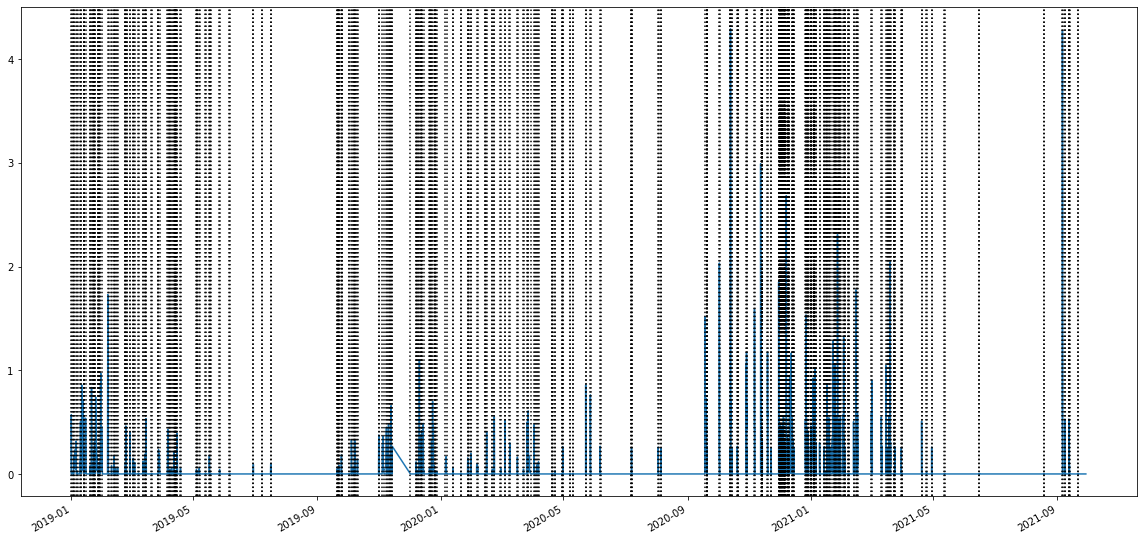

In [5]:
df_dates = pd.DataFrame(index=df_weather_clean.index)
precipitation = pd.concat([pd.Series({'2019-01-01 00:15:00': 0}),df_weather_clean.precipitation])
precipitation.index = pd.to_datetime(precipitation.index)
print(precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
#print(df_dates["rain_start"])
dates_rain_start = df_dates.rain_start.index[df_dates.rain_start.notna()]
dates_rain_stop = df_dates.rain_stop.index[df_dates.rain_stop.notna()]
dates = dates_rain_start.union(dates_rain_stop)
ax = precipitation.plot(figsize=(20,10))
for d in dates:
    ax.axvline(x=d, color='k', linestyle=':')
plt.show()
#df_dates.info()

### Filter out light rains
Any rain with maximum precipitation less than 0.8 is considered light.

In [6]:
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= 0.8:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]
dates_rain_start_filtered.shape

(29,)

# Detect changepoints
We iterate over all possible rains, which correspond to possible time-windows where a changepoint may occur. In each of those locations, we define a time window before the assumed changepoint as our training set, one time-window coming right after the training set but before the time of the assumed changepoint, as our validation set, and one time window after the assumed changepoint, as our test set. The intuition is the following: our training set corresponds to a time window where our targe value remains relatively low. Similar behavior is expected in our validation test. We use the training set to train a regression model, and we use the corresponding validation test to validate.  Then, if a changepoint is indeed located in the assumed time window, the real target value in our test set will deviate significantly from the prediction of our model. In particular, in this specific experiment, we are only interested in sudden increases of the target value (rather than any kind of deviation in the test set).  


## Initialize variables

In [7]:
w1 = 15 # window of days to train (before the rain)
w2 = 5  # window of days to validate (before the rain)
w3 = 5 # window of days to validate (after the rain)
training_scores = np.zeros((dates_rain_start_filtered.size, 5))
validation_scores = np.zeros((dates_rain_start_filtered.size, 5))
test_scores = np.zeros((dates_rain_start_filtered.size, 5))
scaler = MinMaxScaler()
df_strings_clean = pd.DataFrame(scaler.fit_transform(df_strings_clean), columns=df_strings_clean.columns, index=df_strings_clean.index)

## For each rain, train, validate and test.

In [9]:
preds_val = []
preds_test = []
preds_train = []
for i in range(dates_rain_start_filtered.size):
    d1 = dates_rain_start_filtered[i]
    d2 = dates_rain_stop_filtered[i]
    #changepoint_scores(df_strings_clean, d1, d2, w1, w2, w3)
    try:
         y_pred_train, score_train, y_pred_val, score_val, y_pred_test, score_test = changepoint_scores(df_strings_clean, d1, d2, w1, w2, w3)
         preds_train.append(y_pred_train)
         preds_test.append(y_pred_test)
         preds_val.append(y_pred_val)
         training_scores[i] = score_train
         validation_scores[i] = score_val
         test_scores[i] = score_test
    except:
         preds_train.append([])
         preds_test.append([])
         preds_val.append([])

## Plot the results that deviate most from the predictions

[-0.03638321 -0.03291681 -0.02681423 -0.02406125 -0.01952481]


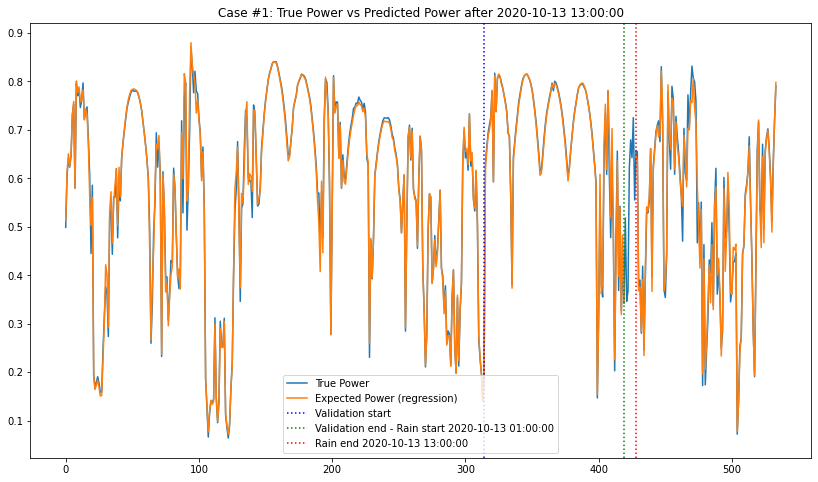

Metrics before the rain (training_set):
MAE:0.010  
ME(true-pred):-0.000 
MAPE:0.017 
R2: 0.994

Metrics before the rain (validation_set):
MAE:0.008  
ME(true-pred):-0.001 
MAPE:0.012 
MPE:-0.001 
R2: 0.987

Metrics after the rain (test_set):
MAE:0.019  
ME(true-pred):0.004  
MAPE:0.036 
MPE:0.007 
R2: 0.975

Precipitation during the rain interval:
Mean: 0.39787262202127655, Max: 4.29167765, Min: 0.004166667


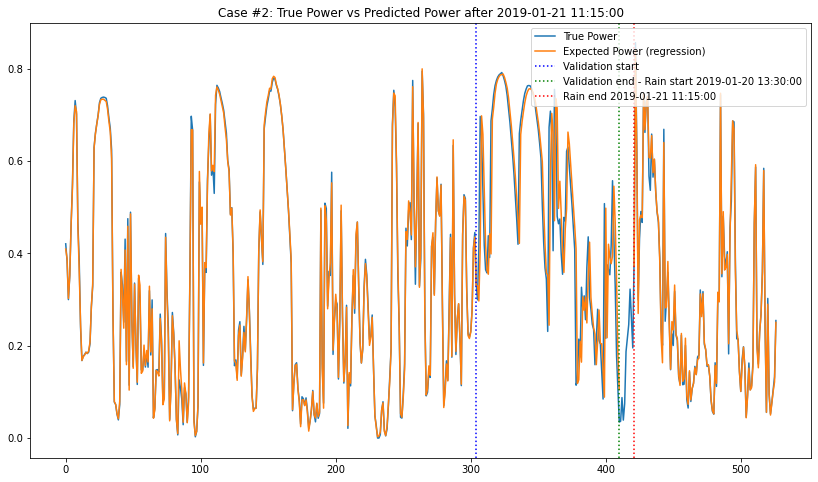

Metrics before the rain (training_set):
MAE:0.007  
ME(true-pred):0.000 
MAPE:0.021 
R2: 0.998

Metrics before the rain (validation_set):
MAE:0.010  
ME(true-pred):0.000 
MAPE:0.019 
MPE:0.000 
R2: 0.992

Metrics after the rain (test_set):
MAE:0.010  
ME(true-pred):-0.001  
MAPE:0.033 
MPE:-0.003 
R2: 0.994

Precipitation during the rain interval:
Mean: 0.3395348876511628, Max: 0.833333375, Min: 0.004166667


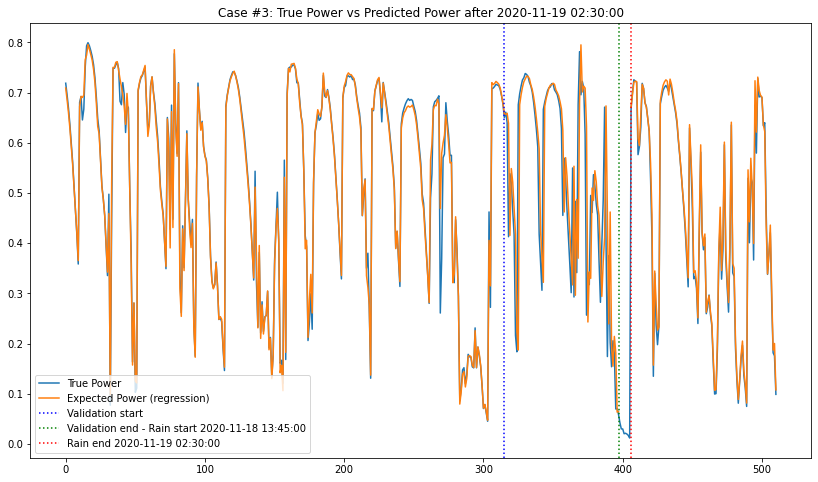

Metrics before the rain (training_set):
MAE:0.010  
ME(true-pred):0.000 
MAPE:0.019 
R2: 0.988

Metrics before the rain (validation_set):
MAE:0.009  
ME(true-pred):-0.004 
MAPE:0.018 
MPE:-0.007 
R2: 0.991

Metrics after the rain (test_set):
MAE:0.012  
ME(true-pred):-0.011  
MAPE:0.027 
MPE:-0.024 
R2: 0.994

Precipitation during the rain interval:
Mean: 0.32700048924, Max: 1.17502215, Min: 0.004166667


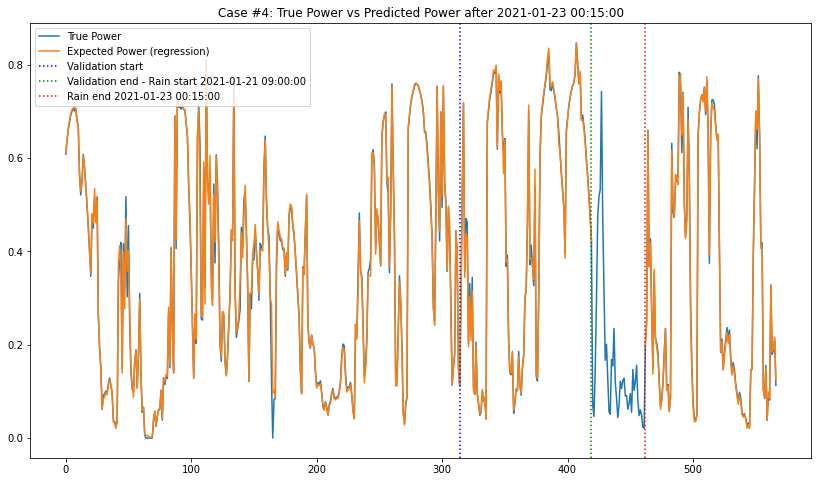

Metrics before the rain (training_set):
MAE:0.009  
ME(true-pred):0.000 
MAPE:0.027 
R2: 0.993

Metrics before the rain (validation_set):
MAE:0.007  
ME(true-pred):0.001 
MAPE:0.015 
MPE:0.001 
R2: 0.998

Metrics after the rain (test_set):
MAE:0.008  
ME(true-pred):0.003  
MAPE:0.024 
MPE:0.008 
R2: 0.998

Precipitation during the rain interval:
Mean: 0.22019246093910255, Max: 1.2875, Min: 0.004166667


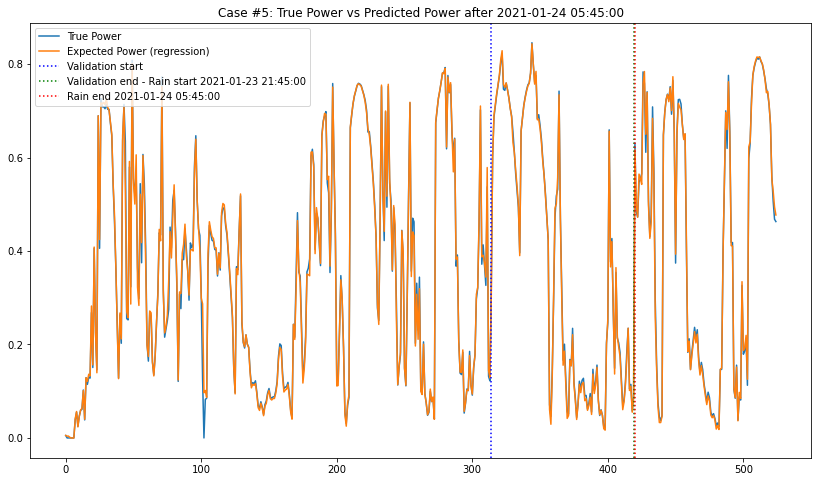

Metrics before the rain (training_set):
MAE:0.009  
ME(true-pred):-0.000 
MAPE:0.026 
R2: 0.994

Metrics before the rain (validation_set):
MAE:0.006  
ME(true-pred):0.003 
MAPE:0.016 
MPE:0.008 
R2: 0.999

Metrics after the rain (test_set):
MAE:0.008  
ME(true-pred):0.001  
MAPE:0.020 
MPE:0.002 
R2: 0.998

Precipitation during the rain interval:
Mean: 0.4677422487096774, Max: 1.05833335, Min: 0.004166667


In [12]:
score_column = 3 # 0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe
thrsh = np.sort(validation_scores[:,score_column]) # take the top 10 validation scores
thrsh = thrsh[10]
indices_test = np.where(validation_scores <= thrsh)
mask = np.ones(test_scores.shape, dtype=bool)
mask[indices_test] = False
test_scores[mask] = np.finfo('d').min
indices = np.argsort(-test_scores[:, score_column])[:5] 
print(np.sort(-test_scores[:, score_column])[:5] )
for n, i in enumerate(indices):
    d1 = dates_rain_start_filtered[i]
    d2 = dates_rain_stop_filtered[i]
    window_before = pd.to_datetime(d1) - pd.Timedelta(days=w1)-pd.Timedelta(days=w2)
    window_after = pd.to_datetime(d2) + pd.Timedelta(days=w3)
    
    plt.figure(figsize=(14,8))
    plt.title(f"Case #{n + 1}: True Power vs Predicted Power after {d2}")
    plt.plot(df_strings_clean.loc[window_before:window_after].power.values, label="True Power")
    nobs = df_strings_clean.loc[window_before:window_after].shape[0]
    if (np.array(preds_train[i]).shape[0]) == 0:
        continue
    preds_empty = [np.nan] * (nobs - len(preds_train[i]) - len(preds_val[i])-len(preds_test[i])) 
    preds = np.hstack([preds_train[i], preds_val[i], preds_empty, preds_test[i]])
    plt.plot(preds, label="Expected Power (regression)")
    plt.axvline(x=preds_train[i].shape[0] - 1, color='b', linestyle=':', label=f'Validation start ')
    plt.axvline(x=preds_train[i].shape[0]+preds_val[i].shape[0] - 1, color='g', linestyle=':', label=f'Validation end - Rain start {d1}')
    plt.axvline(x=preds_train[i].shape[0]+preds_val[i].shape[0] + len(preds_empty), color='r', linestyle=':', label=f'Rain end {d2}')
    plt.legend()
    plt.show()
    print('Metrics before the rain (training_set):')
    print(f'MAE:{training_scores[i, 1]:.3f}  \nME(true-pred):{training_scores[i,2]:.3f} \nMAPE:{training_scores[i, 3]:.3f} \nR2: {-training_scores[i, 0]:.3f}\n')
    print('Metrics before the rain (validation_set):')
    print(f'MAE:{validation_scores[i, 1]:.3f}  \nME(true-pred):{validation_scores[i,2]:.3f} \nMAPE:{validation_scores[i, 3]:.3f} \nMPE:{validation_scores[i, 4]:.3f} \nR2: {-validation_scores[i, 0]:.3f}\n')
    print('Metrics after the rain (test_set):')
    print(f'MAE:{test_scores[i, 1]:.3f}  \nME(true-pred):{test_scores[i,2]:.3f}  \nMAPE:{test_scores[i, 3]:.3f} \nMPE:{test_scores[i, 4]:.3f} \nR2: {-test_scores[i, 0]:.3f}')
    
    precip = df_weather_clean.loc[d1:d2][1:-1].precipitation.values
    p_min = precip.min()
    p_max = precip.max()
    p_mean = precip.mean()
    
    print('\nPrecipitation during the rain interval:')
    print(f'Mean: {p_mean}, Max: {p_max}, Min: {p_min}')